In [78]:
import pyodbc 
import pandas as pd
from matplotlib import pyplot
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Contagem do número de nascimentos por data e município de residência

In [ ]:
host = "200.137.215.27"
port = 31010
uid = "***"
pwd = "***"
driver = "Dremio Connector"

cnxn = pyodbc.connect("Driver={};ConnectionType=Direct;HOST={};PORT={};AuthenticationType=Plain;UID={};PWD={}".format(driver, host,port,uid,pwd),autocommit=True)


Contagem da base SINASC para todos os anos 

In [14]:
sql_total = '''SELECT CODMUNRES, MES_ANO, COUNT(*) AS TOTAL FROM (
                    SELECT CODMUNRES, SUBSTRING(DTNASC, 3, 6) AS MES_ANO
                    FROM Dados.sinasc.DN
                    WHERE CODMUNRES = '520870')
                    GROUP BY CODMUNRES, MES_ANO'''

dataframe1 = pd.read_sql(sql_total,cnxn)
dataframe1.head()


,CODMUNRES,MES_ANO,TOTAL
0,520870,092013,1774
1,520870,022009,1520
2,520870,032017,1948
3,520870,042011,1830
4,520870,032011,1917


Contagem da base SINASC 2020 - Preliminar

In [16]:
sql_2020 = '''SELECT CODMUNRES, MES_ANO, COUNT(*) AS TOTAL FROM (
                    SELECT CODMUNRES, SUBSTRING(DTNASC, 3, 6) AS MES_ANO
                    FROM Dados.sinasc.preliminar.sinasc_2020
                    WHERE CODMUNRES = '520870')
                    GROUP BY CODMUNRES, MES_ANO'''

dataframe2020 = pd.read_sql(sql_2020,cnxn)
dataframe2020.head()

,CODMUNRES,MES_ANO,TOTAL
0,520870,082020,1565
1,520870,032020,1829
2,520870,042020,1773
3,520870,022020,1562
4,520870,112020,1408


Contagem da base SINASC 2021 - Preliminar

In [17]:
sql_2021 = ''' SELECT CODMUNRES, MES_ANO, COUNT(*) AS TOTAL FROM (
                    SELECT CODMUNRES, SUBSTRING(DTNASC, 3, 6) AS MES_ANO
                    FROM Dados.sinasc.preliminar.sinasc_2021
                    WHERE CODMUNRES = '520870')
                    GROUP BY CODMUNRES, MES_ANO '''

dataframe2021 = pd.read_sql(sql_2021,cnxn)
dataframe2021.head()

,CODMUNRES,MES_ANO,TOTAL
0,520870,062021,1568
1,520870,012021,1498
2,520870,072021,1551
3,520870,052021,1582
4,520870,022021,1498


In [57]:
df = pd.concat([dataframe1,dataframe2020,dataframe2021])
df.head()

,CODMUNRES,MES_ANO,TOTAL
0,520870,092013,1774
1,520870,022009,1520
2,520870,032017,1948
3,520870,042011,1830
4,520870,032011,1917


In [58]:
df['MES_ANO'] = pd.to_datetime(df['MES_ANO'], format='%m%Y')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202 entries, 0 to 9
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   CODMUNRES  202 non-null    object        
 1   MES_ANO    202 non-null    datetime64[ns]
 2   TOTAL      202 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 6.3+ KB


# Análise exploratória dos dados

Tutorial: https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

In [61]:
df.sort_values(by = ['MES_ANO'])

,CODMUNRES,MES_ANO,TOTAL
45,520870,2006-01-01,1513
6,520870,2006-02-01,1527
105,520870,2006-03-01,1905
115,520870,2006-04-01,1759
112,520870,2006-05-01,1783
...,...,...,...
0,520870,2021-06-01,1568
2,520870,2021-07-01,1551
6,520870,2021-08-01,1474
9,520870,2021-09-01,1510


In [65]:
df = df[df['MES_ANO'] < "2021-10-01"]

<AxesSubplot:xlabel='MES_ANO'>

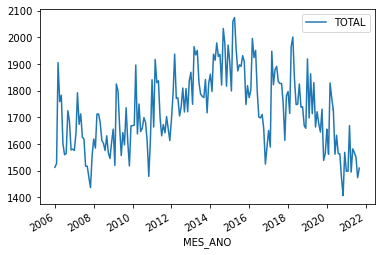

In [66]:
df.plot('MES_ANO','TOTAL')

In [67]:
df = df[['MES_ANO', 'TOTAL']]
df.columns = ['ds','y']

In [69]:
df.sort_values(by = ['ds'])

,ds,y
45,2006-01-01,1513
6,2006-02-01,1527
105,2006-03-01,1905
115,2006-04-01,1759
112,2006-05-01,1783
...,...,...
3,2021-05-01,1582
0,2021-06-01,1568
2,2021-07-01,1551
6,2021-08-01,1474


# Prophet 

In [101]:
train = df.loc[df["ds"] < "2020-09-01"]
test = df.loc[df["ds"] >= "2020-09-01"]

<AxesSubplot:xlabel='ds'>

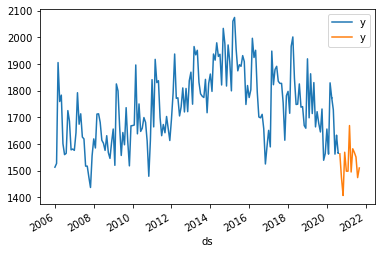

In [102]:
axes = plt.gca()

train.plot('ds','y', ax = axes)
test.plot('ds','y', ax = axes)

In [98]:
model = Prophet()

In [99]:
model.fit(train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [112]:
future = model.make_future_dataframe(periods=12, freq = 'MS')
future

,ds
0,2006-01-01
1,2006-02-01
2,2006-03-01
3,2006-04-01
4,2006-05-01
...,...
184,2021-05-01
185,2021-06-01
186,2021-07-01
187,2021-08-01


In [113]:
forecast = model.predict(future)

In [114]:
forecast[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2006-01-01,1610.171232,1526.339765,1691.342248
1,2006-02-01,1537.720554,1447.506591,1621.789325
2,2006-03-01,1779.812167,1698.780181,1862.497541
3,2006-04-01,1695.924538,1615.367007,1779.308376
4,2006-05-01,1698.370816,1623.228935,1782.665888
...,...,...,...,...
184,2021-05-01,1688.066594,1604.428514,1770.842615
185,2021-06-01,1575.150709,1494.309066,1654.049024
186,2021-07-01,1575.629013,1494.835043,1656.991528
187,2021-08-01,1554.788799,1475.920421,1641.889421


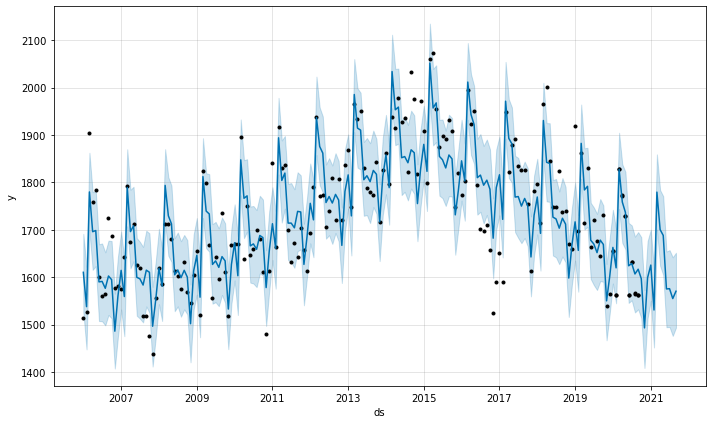

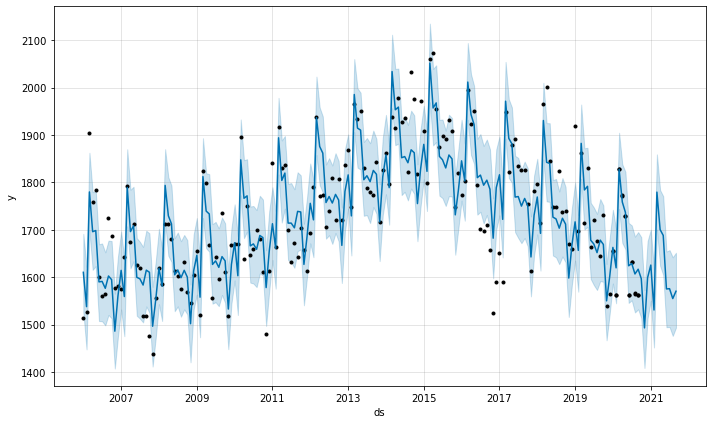

In [115]:
model.plot(forecast)

# Comparando predito e observado

In [117]:
predito = forecast.loc[forecast["ds"] >= "2020-09-01"]
predito = predito[['ds','yhat','yhat_lower','yhat_upper']]
predito.head()

,ds,yhat,yhat_lower,yhat_upper
176,2020-09-01,1616.700567,1532.075136,1695.052717
177,2020-10-01,1596.900808,1513.946749,1684.358027
178,2020-11-01,1492.903292,1408.308818,1572.632620
179,2020-12-01,1598.890427,1513.663354,1675.938784
180,2021-01-01,1625.476536,1549.923989,1700.208268


In [127]:
predito_observado = predito.merge(test, on = 'ds', how = 'left')
predito_observado = predito_observado[['ds','yhat','y']]
predito_observado.head()

,ds,yhat,y
0,2020-09-01,1616.700567,1563
1,2020-09-01,1616.700567,1562
2,2020-10-01,1596.900808,1474
3,2020-10-01,1596.900808,1474
4,2020-11-01,1492.903292,1407


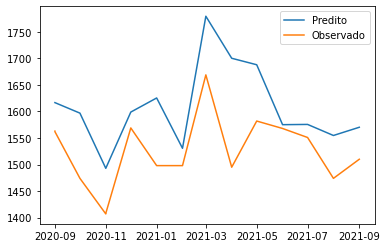

In [134]:
pyplot.plot(predito_observado['ds'], predito_observado['yhat'], label = "Predito")
pyplot.plot(predito_observado['ds'], predito_observado['y'], label = "Observado")
pyplot.legend()
pyplot.show()

# Métricas

In [136]:
mean_absolute_error(predito_observado['yhat'], predito_observado['y'])

78.79917625514746

In [138]:
mean_absolute_percentage_error(predito_observado['yhat'], predito_observado['y'])

0.048747134321033496